# Evaluation Metrics

In [ ]:
# import os
# import cv2
# import csv
import kornia as K
# import kornia.feature as KF
# import kornia.geometry.transform as KT
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import matplotlib as mpl
# import matplotlib.gridspec as gridspec
# from matplotlib.ticker import MaxNLocator
# import seaborn as sns
import numpy as np
import torch
# import torch.nn.functional as F
import skimage as ski
# import pandas as pd
# from scipy.stats import t
# import math
# from tqdm import tqdm

from utils import convert_image_to_tensor
from metrics import mse, mse_masked, ncc, ncc_masked, local_ncc, local_ncc_masked, mutual_information, nmi_skimage, nmi, nmi_masked, ssim_kornia, ssim_skimage, ssim_masked, iou, hausdorff
from plotting import plot_image_pair, plot_overlay
from DatasetTools.LeafImageSeries import LeafDataset
from masking import fetch_image_mask_pair

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="monai"
)


<frozen importlib._bootstrap_external>:1329: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
/layers/paketo-buildpacks_poetry-install/poetry-venv/datascience-python-renku-dependencies-xS3fZVNL-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1",
    # leaf_uid="ESWW0070023_6", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'cropped_images', 'rois', 'images', 'keypoints'),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...


Loading cropped images...
Loading ROIs...
Loading Target Masks...
Loading Leaf Masks...
Loading Segmentation Masks...
Loading target images...
Loading keypoints...


In [ ]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 1, 2, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, moving, 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, moving_mask, 0, 2)
fig.show()

## IoU

In [ ]:
pred = convert_image_to_tensor(moving_mask).long()
target = convert_image_to_tensor(fixed_mask).long()

print("Pred unique:", torch.unique(pred))
print("Target unique:", torch.unique(target))

print("Pred counts:", torch.bincount(pred.flatten()))
print("Target counts:", torch.bincount(target.flatten()))

Pred unique: tensor([0, 1])
Target unique: tensor([0, 1])
Pred counts: tensor([ 258061, 1003934])
Target counts: tensor([310924, 951071])
Equal masks: False


In [8]:
print(iou(None, fixed_mask, None, moving_mask).item())
print(iou(None, fixed_mask, None, fixed_mask).item())

0.9106493592262268
1.0


IoU of background is smaller than IoU of foreground/leaf $=>$ relativ to total number of background pixels, more false positives. BUT background is smaller than foreground. IoU punishes smaller class more harshly for boundary errors.

## MSE

In [75]:
# sanity check
print(f"Standard MSE: {mse(fixed, moving)}")
print(f"'Masked' MSE: {mse_masked(fixed, torch.ones_like(convert_image_to_tensor(fixed)), moving, torch.ones_like(convert_image_to_tensor(moving)))}")

print(f"Masked MSE: {mse_masked(fixed, fixed_mask, moving, moving_mask)}")

Standard MSE: 0.01612808369100094
'Masked' MSE: 0.01612808369100094
Masked MSE: 0.017626041546463966


## NCC

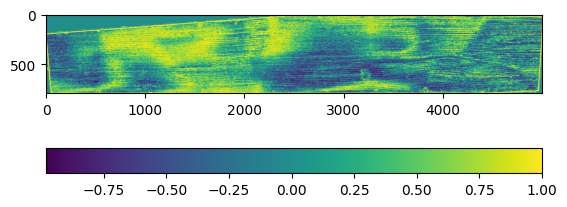

In [47]:
res = local_ncc(fixed, moving, reduction='none')
img = plt.imshow(K.tensor_to_image(res))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.show()

In [136]:
# sanity check
print(f"Standard NCC: {ncc(fixed, moving)}")
print(f"'Masked' NCC: {ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")
print(f"Inverted Images: {ncc(img1, img2)}")
print(f"Blackened Images: {ncc(img3, img4)}")

print(f"Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask)}")
print(f"'and' Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask, mask_mode='both')}")

Standard NCC: 0.8246079683303833
'Masked' NCC: 0.8246080279350281
Inverted Images: 0.9106995463371277
Blackened Images: 0.956824004650116
Masked NCC: 0.3901742696762085
'and' Masked NCC: 0.3908914029598236


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

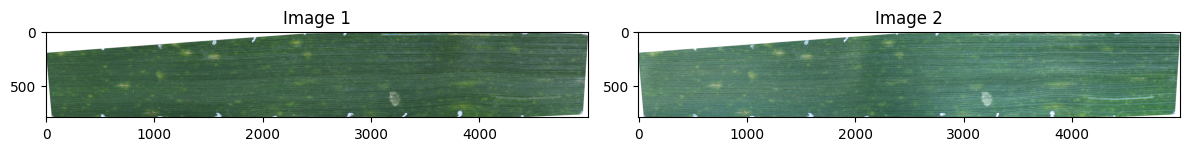

In [123]:
img1 = convert_image_to_tensor(fixed)
img2 = convert_image_to_tensor(moving)
img1[K.color.grayscale_to_rgb(fixed_mask) == 0] = 1
img2[K.color.grayscale_to_rgb(moving_mask) == 0] = 1
plot_image_pair(img1, img2)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

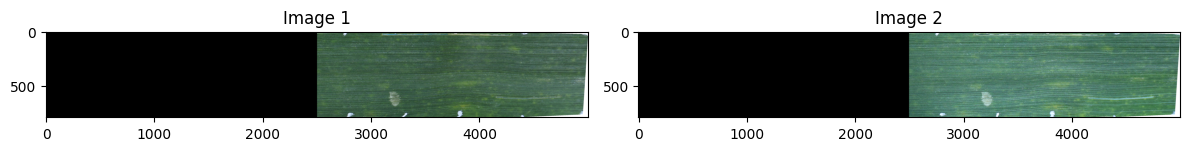

In [135]:
img3 = img1.clone()
img4 = img2.clone()
img3[0,:,:,:2500] = 0
img4[0,:,:,:2500] = 0
plot_image_pair(img3, img4)

### Local NCC

In [111]:
# sanity check
print(f"Standard LNCC: {local_ncc(fixed, moving)}")
print(f"'Masked' LNCC: {local_ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")

print(f"Masked LNCC: {local_ncc_masked(fixed, fixed_mask, moving, moving_mask)}")

test
Standard LNCC: 0.17045828700065613
'Masked' LNCC: 0.16544589400291443
Masked LNCC: 0.15299779176712036


## Mutual Information

In [6]:
# sanity check
print(f"Old MI: {mutual_information(fixed, moving)}")
print(f"Skimage NMI: {nmi_skimage(fixed, moving)}")
print(f"New MI: {nmi(fixed, moving)}")
print(f"'Masked' MI: {nmi_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")
print(f"Masked MI: {nmi_masked(fixed, fixed_mask, moving, moving_mask)}")
print(f"Masked MI of same image: {nmi_masked(fixed, fixed_mask, fixed, fixed_mask)}")
print(f"New MI of same image: {nmi(fixed, fixed)}")
print(f"Skimage NMI of same image: {nmi_skimage(fixed, fixed)}")
print(f"Old MI of same image: {mutual_information(fixed, fixed)}")

Old MI: 0.3668353259563446
Skimage NMI: 1.0775757784357562
New MI: 1.0758801698684692
'Masked' MI: 1.07589852809906
Masked MI: 1.0123107433319092
Masked MI of same image: 1.1134573221206665
New MI of same image: 1.1742256879806519
Skimage NMI of same image: 2.0
Old MI of same image: 3.190188407897949


In [77]:
for sigma in [0.1, 0.05, 0.02, 0.01]:
    print(nmi(fixed, fixed, sigma=sigma))

0.1
tensor(1.0570)
0.05
tensor(1.1512)
0.02
tensor(1.3409)
0.01
tensor(1.6236)


In [79]:
print(nmi(fixed, fixed, bins=32, sigma_ratio=0.5))
print(nmi(fixed, fixed, bins=64, sigma_ratio=0.5))

tensor(0.0161)
tensor(1.4153)
tensor(0.0079)
tensor(1.4938)


In [69]:
def parzen_kernel(x: torch.Tensor):
    x = torch.abs(x)

    return torch.where(
        x < 0.5,
        -1.8 * x**2 - 0.1 * x + 1,
        torch.where(
            x <= 1,
            1.8 * x**2 - 3.7 * x + 1.9,
            torch.zeros_like(x)
        )
    )

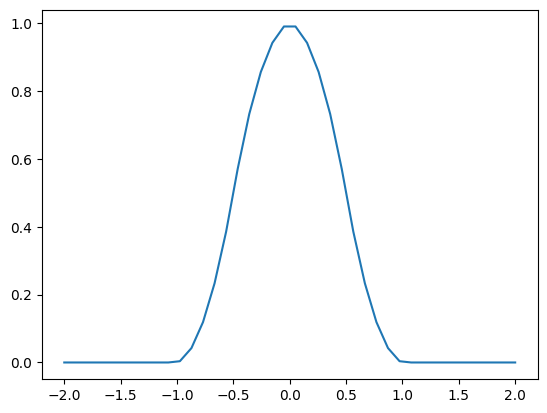

In [70]:
x = torch.linspace(-2, 2, 40)
out = parzen_kernel(x)
plt.plot(x, out)
plt.show()

In [75]:
def nmi(img1, img2, reduction="mean", bins=32, sigma_ratio=1.0, sigma=None, eps=1e-13):
    """
    Parzen-window Normalized Mutual Information (NMI)

    A, B : tensors of same shape, intensities in [0,1]
    W    : same shape, 1 = valid pixel, 0 = invalid
    bins : number of Parzen bins
    sigma: Gaussian kernel width

    Returns: scalar NMI
    """

    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)

    # Convert to grayscale
    img1 = K.color.rgb_to_grayscale(img1)
    img2 = K.color.rgb_to_grayscale(img2)

    # flatten
    img1 = img1.reshape(-1)
    img2 = img2.reshape(-1)

    device = img1.device

    # bin centers
    # shape: (1, bins)
    bin_centers = torch.linspace(0.0, 1.0, bins, device=device).unsqueeze(0)
    bin_width = torch.mean(torch.diff(bin_centers))
    if sigma is None:
        sigma = bin_width * sigma_ratio

    print(sigma)

    # Parzen soft assignment
    # shape: (N, bins)
    img1 = img1.unsqueeze(1)
    img2 = img2.unsqueeze(1)

    hist1 = torch.exp(-(img1 - bin_centers)**2 / (2 * sigma**2))
    hist2 = torch.exp(-(img2 - bin_centers)**2 / (2 * sigma**2))

    # hist1 = parzen_kernel(img1 - bin_centers)
    # hist2 = parzen_kernel(img2 - bin_centers)


    # normalize kernels
    hist1 = hist1 / (hist1.sum(dim=1, keepdim=True) + eps)
    hist2 = hist2 / (hist2.sum(dim=1, keepdim=True) + eps)
    # print(f"P1 alt: {torch.mean(hist1, dim=0)}")

    # joint Parzen histogram
    # shape: (bins, bins)
    P12 = hist1.T @ hist2
    
    # normalize to probabilities
    P12 = P12 / (P12.sum() + eps)

    # marginals
    P1 = torch.mean(hist1, dim=0)
    P2 = torch.mean(hist2, dim=0)    

    # entropies
    H1  = -(P1  * torch.log(P1  + eps)).sum()
    H2  = -(P2  * torch.log(P2  + eps)).sum()
    H12 = -(P12 * torch.log(P12 + eps)).sum()
    # print("--------------------")
    # print(H1)
    # print(H12)
    

    # normalized mutual information
    NMI = (H1 + H2) / H12

    return NMI


In [81]:
print(nmi(fixed, fixed, bins=64, sigma=0.01)) # target: 1.7–1.9
print(nmi(fixed, fixed, bins=32, sigma=0.02)) # target: 1.5–1.8
print(nmi(fixed, fixed, bins=32, sigma=0.05)) # target: 1.2–1.4

0.01
tensor(1.4152)
0.02
tensor(1.3409)
0.05
tensor(1.1512)


In [12]:
# identical vs random
print(nmi(fixed, fixed))
print(nmi(fixed, torch.randn_like(fixed)))

tensor(1.1742)
tensor(0.8343)


## SSIM

In [4]:
def ssim_masked(img1, img1_mask, img2, img2_mask, window_size=11, reduction='mean'):
    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)


    ssim_map = K.metrics.ssim(img1, img2, window_size, eps=1e-12, padding='same', max_val=1.0)
    if reduction == 'mean':
        return ssim_map.mean(dim=(1, 2, 3))
    elif reduction == 'none':
        return ssim_map
    else:
        raise ValueError("reduction must be either 'mean' or 'none'")


In [23]:
ksim = ssim_kornia(fixed, moving, reduction='mean')
ksim_img = ssim_kornia(fixed, moving, reduction='none').squeeze(0)
skisim, skisim_img = ssim_skimage(fixed, moving, return_img=True)
skisim_img = convert_image_to_tensor(skisim_img)
print(f"Kornia SSIM: {ksim}")
print(f"Skimage SSIM: {skisim}")
print(f"Diff: {ksim-skisim}")
print(f"Kornia SSIM Image: {ksim_img.shape}")
print(f"Skimage SSIM Image: {skisim_img.shape}")
print(f"Diff: {torch.mean(ksim_img-skisim_img)}")

Kornia SSIM: 0.432451456785202
Skimage SSIM: 0.4262583553791046
Diff: 0.006193101406097412
Kornia SSIM Image: torch.Size([3, 791, 4999])
Skimage SSIM Image: torch.Size([3, 791, 4999])
Diff: 0.0011111005442216992


## Hausdorff Distance

In [10]:
print(hausdorff(None, fixed_mask, None, moving_mask).item())
print(hausdorff(None, fixed_mask, None, fixed_mask).item())

169.85818481445312
0.0


95%-Hausdorff distance = the distance such that 95\% of boundary points from the predicted (moving) mask are within that distance to the ground truth boundary (and vice versa).

=> “What is the typical worst-case boundary error?”